## EECS 731 Project 5: World Wide Products Inc.

In this project, I will be reading from a dataset of [product demands](https://www.kaggle.com/felixzhao/productdemandforecasting) and performing Time Series forecasting with the goal of predicting the future demand for the most commonly ordered product. In particular, I will perform forecasting across two different time frames:

- The monthly product demand over multiple years (i.e. Year+Month combination), and
- The annual product demand on a per-day basis (i.e. Month+Day combination).

Due to the size of the original dataset, I do not include in the data/ directory. I will, however, save the processed dataset I create and use to the data/processed/ directory.

### Python Imports

In [1]:
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPRegressor

### Create *sklearn* Objects

To reduce the dataset values that will be evaluated later, I use a label encoder. In this case, I don't perform column normalization(s) as the Gradient Boosting model tested can't handle continuous inputs/outputs.

I also employ the TimeSeriesSplit object in order to create train and test sets.

In [2]:
encoder = LabelEncoder()
tscv = TimeSeriesSplit(n_splits=5)

### Create Time Series Models

In this project, I test the following three models:

- Linear Regression
- Gradient Boosting
- Neural Network (MLP)

For the Neural Network model, I arbitrarily set the number of max iterations to 100,000 so that the model can converge (I originally had it at 10,000 iterations but found that the model was still unable to converge in some instances).

In [3]:
linearReg_model = LinearRegression()
gradBoost_model = GradientBoostingClassifier()
neuralNetwork_model = MLPRegressor(max_iter=100000)

### Reading the Raw Dataset

In the process of reading the original dataset, I also remove any entries/rows that contain empty values

In [4]:
demand_list = pd.read_csv("../data/raw/demand.csv").dropna()
demand_list

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


### Extracting a Dataset for the Most Ordered Product

To find the most commonly ordered product (i.e. the product with the most rows in the dataset), I count the number of instances for each unique product code. Once found, I then extract the Date and Order_Demand columns only as the remaining columns (Warehouse, Product_Code, etc.) all contain the same respective value. As such, they wouldn't be helpful for predicting future demand.

In [5]:
product = demand_list["Product_Code"].value_counts().keys()[0]
product_list = demand_list[demand_list["Product_Code"]==product]
product_list = product_list.loc[:,("Date","Order_Demand")]

### Creating the Desired Timeframes

In the original dataset, the dates for each order are delimited by a "/" characeter. With this, I separate the dates into three different columns for the Year, Month and Day, respectively. In creating the Month and Day columns, I ensure all entries have two digits so that the combined datasets I create can remain in chronological order.

In [6]:
date_lists = product_list["Date"].str.split("/", expand=True)
years = date_lists[0]
months = date_lists[1].str.zfill(2)
days = date_lists[2].str.zfill(2)

I then combine the three columns into two new columns, one for each of the desired time frames detailed above.

In [7]:
year_month = pd.to_numeric(years+months)
year_month

276        201204
282        201205
289        201206
292        201207
296        201208
            ...  
1046514    201610
1046515    201609
1046516    201611
1046517    201612
1046518    201612
Length: 16936, dtype: int64

In [8]:
month_day = pd.to_numeric(months+days)
month_day

276         418
282         521
289         626
292         717
296         824
           ... 
1046514    1003
1046515     916
1046516    1101
1046517    1201
1046518    1209
Length: 16936, dtype: int64

Note that, without the additional 0 for single digit months and days, the combined datasets wouldn't be chronological, hence why the two digit minimum is necessary.

### Creating the Processed Dataset

Before creating a new dataframe, one final step that needs to be done is removing parentheses characters from the orders column as some entries contain them, thus preventing the column from being converted to any numeric type.

In [9]:
orders = product_list["Order_Demand"].str.replace(r"\(","")
orders = orders.str.replace(r"\)","")
orders = pd.to_numeric(orders)
orders

276         80000
282         70000
289         80000
292        100000
296        100000
            ...  
1046514     20000
1046515     10000
1046516     30000
1046517     20000
1046518     20000
Name: Order_Demand, Length: 16936, dtype: int64

Once done, I then create a new processed dataset with all of the desired features and orders which I then save to the datasets/processed/ directory.

In [10]:
product_dataset = pd.DataFrame({"Year":years,"Month":months,"Day":days,"Year+Month":year_month,"Month+Day":month_day,"Order":orders})
product_dataset.to_csv("../data/processed/product_dataset.csv")
product_dataset

,Year,Month,Day,Year+Month,Month+Day,Order
276,2012,04,18,201204,418,80000
282,2012,05,21,201205,521,70000
289,2012,06,26,201206,626,80000
292,2012,07,17,201207,717,100000
296,2012,08,24,201208,824,100000
...,...,...,...,...,...,...
1046514,2016,10,03,201610,1003,20000
1046515,2016,09,16,201609,916,10000
1046516,2016,11,01,201611,1101,30000
1046517,2016,12,01,201612,1201,20000


### Timeframe 1: Year+Month

In order to perform Time Series forecasting for the Year+Month combination, I perform the following steps:

- Retrieve the Year+Month and Order columns into two separate datasets.

In [11]:
ym_dataset = product_dataset.groupby("Year+Month", as_index=False).agg({"Order":"sum"}) 
ym_dataset

,Year+Month,Order
0,201201,8911000
1,201202,8131000
2,201203,7775000
3,201204,8960000
4,201205,8475000
...,...,...
56,201609,6960000
57,201610,7727000
58,201611,8814000
59,201612,5653000


In [12]:
ym_feature = ym_dataset["Year+Month"]
ym_order = ym_dataset["Order"]

- Perform label encoding on each dataset. Since the Year+Month column is only a single feature, I also perform a reshape to add a necessary 2nd dimension.

In [13]:
ym_feature = encoder.fit_transform(ym_feature).reshape(-1,1)
ym_order = encoder.fit_transform(ym_order)

- Perform Time Series forecasting with each of the models listed above. In particular, I perform 5-fold cross validation while using the R<sup>2</sup> score to measure each model's performance. When each model is done, I then print its average R<sup>2</sup> score and its standard deviation. 

In [14]:
LRresults = cross_val_score(linearReg_model, ym_feature, ym_order.ravel(), cv=tscv, scoring='r2')
print("Linear Regression: {:.2f} ({:.2f})".format(LRresults.mean(), LRresults.std()))

GBresults = cross_val_score(gradBoost_model, ym_feature, ym_order.ravel(), cv=tscv, scoring='r2')
print("Gradient Boosting: {:.2f} ({:.2f})".format(GBresults.mean(), GBresults.std()))

NNresults = cross_val_score(neuralNetwork_model, ym_feature, ym_order.ravel(), cv=tscv, scoring='r2')
print("Neural Network: {:.2f} ({:.2f})".format(NNresults.mean(), NNresults.std()))

Linear Regression: -1.49 (2.28)
Gradient Boosting: -0.67 (0.74)
Neural Network: -8.00 (15.25)


- Plot the cross validation results. To better visualize how the model performed across each cross-fold, I plotted the individual R<sup>2</sup> scores for each model as well. Note that the x-axis in each plot represents each value of k in the cross fold validation (from 0 to 4) and the y-axis represents the R<sup>2</sup> score at each fold. All subplots are then saved to a single image in the visualizations/ directory.

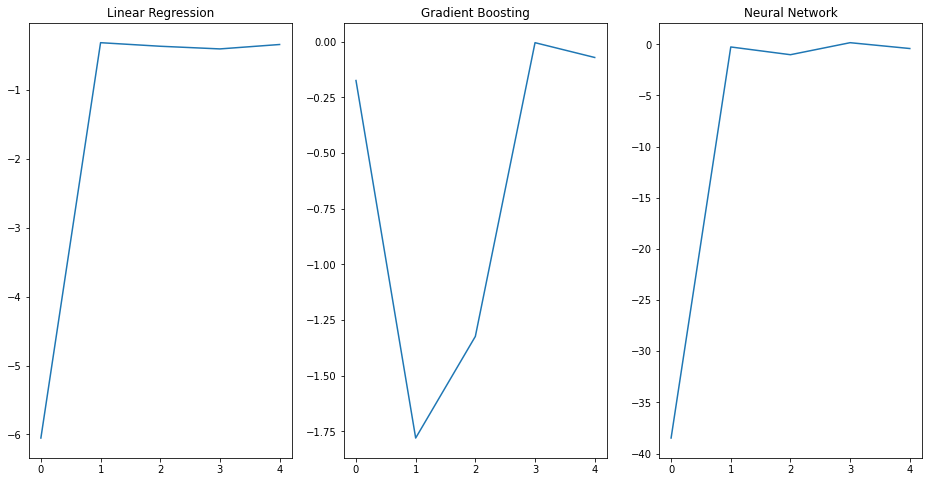

In [15]:
x_vals = range(len(LRresults))
_,graphs = plt.subplots(1,3)

graphs[0].plot(x_vals, LRresults)
graphs[0].set_title("Linear Regression")
graphs[0].set_xticks(x_vals)

graphs[1].plot(x_vals, GBresults)
graphs[1].set_title("Gradient Boosting")
graphs[1].set_xticks(x_vals)

graphs[2].plot(x_vals, NNresults)
graphs[2].set_title("Neural Network")
graphs[2].set_xticks(x_vals)

plt.gcf().set_size_inches((16.0,8.0), forward=False)

### Timeframe 2: Month+Day

In order to perform Time Series forecasting for the Month+Day combination, I perform the same steps and the first timeframe, but I retrieve the Month+Day column in the initial step instead of the Year+Month column.

In [16]:
md_dataset = product_dataset.groupby("Month+Day", as_index=False).agg({"Order":"sum"}) 
md_dataset

,Month+Day,Order
0,105,1812000
1,106,2507000
2,107,1760000
3,108,2709000
4,109,618000
...,...,...
348,1224,1130000
349,1225,839000
350,1226,1588000
351,1227,286000


In [17]:
md_feature = md_dataset["Month+Day"]
md_order = md_dataset["Order"]
md_feature = encoder.fit_transform(md_feature).reshape(-1,1)
md_order = encoder.fit_transform(md_order)

In [18]:
LRresults = cross_val_score(linearReg_model, md_feature, md_order.ravel(), cv=tscv, scoring='r2')
print("Linear Regression: {:.2f} ({:.2f})".format(LRresults.mean(), LRresults.std()))

GBresults = cross_val_score(gradBoost_model, md_feature, md_order.ravel(), cv=tscv, scoring='r2')
print("Gradient Boosting: {:.2f} ({:.2f})".format(GBresults.mean(), GBresults.std()))

NNresults = cross_val_score(neuralNetwork_model, md_feature, md_order.ravel(), cv=tscv, scoring='r2')
print("Neural Network: {:.2f} ({:.2f})".format(NNresults.mean(), NNresults.std()))

Linear Regression: -0.11 (0.07)
Gradient Boosting: -0.36 (0.48)
Neural Network: -3.49 (6.60)


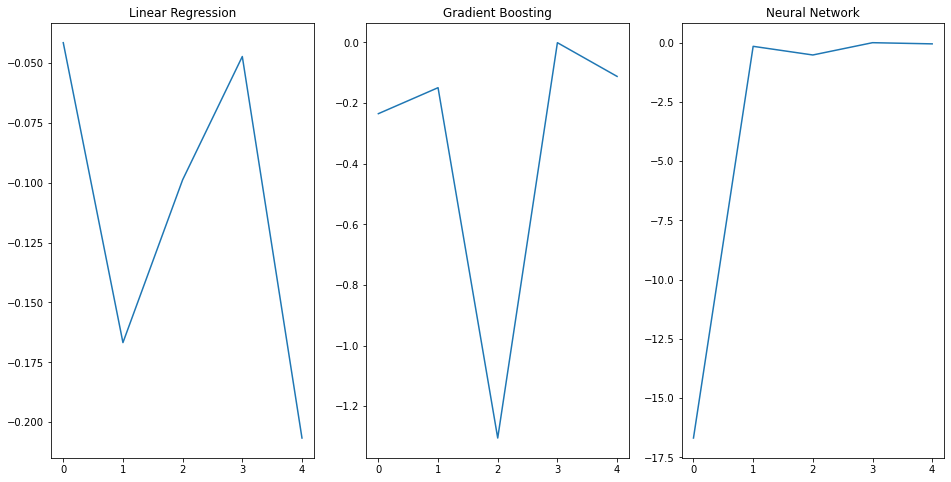

In [19]:
x_vals = range(len(LRresults))
_,graphs = plt.subplots(1,3)

graphs[0].plot(x_vals, LRresults)
graphs[0].set_title("Linear Regression")
graphs[0].set_xticks(x_vals)

graphs[1].plot(x_vals, GBresults)
graphs[1].set_title("Gradient Boosting")
graphs[1].set_xticks(x_vals)

graphs[2].plot(x_vals, NNresults)
graphs[2].set_title("Neural Network")
graphs[2].set_xticks(x_vals)

plt.gcf().set_size_inches((16.0,8.0), forward=False)

## Results

As can be seen in both of the timeframes evaluated, no single model was the best across the board. For the first timeframe, the Gradient Boosting model had the best average performance whereas the Linear Regression Model had the best average performance for the second timeframe. The Neural Network model, though, had extremely variable average performance. On a per-model basis, the reasons for such behavior is likely due to the following:

- For the Linear Regression model, it likely performed better in the second timeframe than the first one because there was less of a chronological dependency in the second timeframe. To be more specific, the second time frame tracked the average annual orders on a per-day basis instead of the order for each individual day across the given years. As such, there was a greater independence across the entries in the dataset for the second timeframe which then allowed for the Linear Regression model to perform better.
- For the Gradient Boosting model, it likely performed the best in the first dataframe as there was a relatively small number of entries in that dataset. As such, it may have been more likely for the model to iteratively progress to a global minimum as opposed to a local minimum, which would have been more probable with a larger dataset. That being said, the Gradient Boosting model also performed relatively well in the second dataframe as well. However, it's performance in that specific instance was overshadowed by the Linear Regression model.
- For the Neural Network model, note that the performance was highly variable across both timeframes. Even though the above results show the model performing very poorly in the first timeframe and decently in the second timeframe, I found that the same behavior wasn't consistently replicated between runs (e.g. in other runs, the model would perform much better on the first timeframe than the second one). This is likely due to how the train and test sets and created when the model is evaluated as they may result in the model overfitting and, hence, having worse performance. 

However, as can be seen in the graphs across both timeframes, all models were able to achieve relatively good performance for one or more k-fold values, which indicates that all models could be effective if trained correctly. In the end, depending on the specific timeframe that is being evaluated and the number of folds used for training and validation, different models may be more applicable than others. Namely, the Linear Regression and Gradient Boosting could both be used with relatively high average performance, whereas the Neural Network model could be employed in more specific circumstances. That being said, in terms of more general applicability, the Neural Network model would be the least desirable as it isn't consistent enough across different k-fold iterations.